In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
from math import sqrt
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from google.colab import files
uploaded= files.upload()

Saving Airlines+Data.xlsx to Airlines+Data.xlsx


In [3]:
airline =pd.read_excel("Airlines+Data.xlsx")
airline

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [4]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [5]:
airline.isna().sum()

Month         0
Passengers    0
dtype: int64

In [6]:
airline.duplicated().sum()

0

In [7]:
airline['Passengers'].describe()

count     96.000000
mean     213.708333
std       71.918216
min      104.000000
25%      156.000000
50%      200.000000
75%      264.750000
max      413.000000
Name: Passengers, dtype: float64

In [8]:
airline.nunique()

Month         96
Passengers    80
dtype: int64

<Axes: >

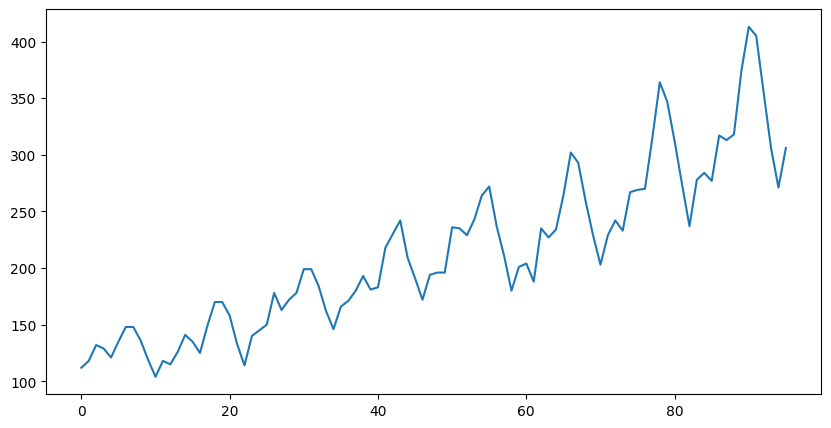

In [9]:
airline.Passengers.plot(figsize=(10,5))

In [10]:
airline.rename({'Month':"Date"},axis=1,inplace=True)
airline

,Date,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [11]:
airline1=airline.copy()
airline1.set_index("Date",inplace=True)

In [12]:
airline1.head()

,Passengers
Date,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [13]:
airline["Date"]=pd.to_datetime(airline.Date,format='%b-%y')
airline['month']= airline.Date.dt.strftime('%b')
airline['year']= airline.Date.dt.strftime("%y")
airline.head()

,Date,Passengers,month,year
0,1995-01-01,112,Jan,95
1,1995-02-01,118,Feb,95
2,1995-03-01,132,Mar,95
3,1995-04-01,129,Apr,95
4,1995-05-01,121,May,95


# **Data Visualization**

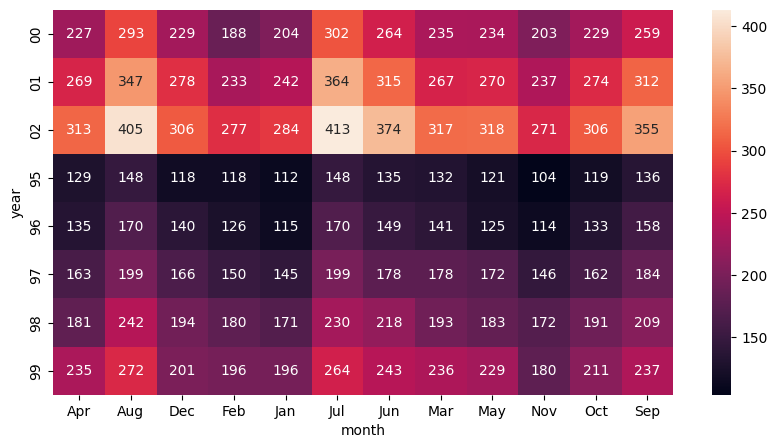

In [14]:
plt.figure(figsize=(10,5))
table= pd.pivot_table(data=airline,values='Passengers',index='year',columns='month',aggfunc='mean',fill_value=0)
sns.heatmap(table,annot=True,fmt='g')
plt.show()

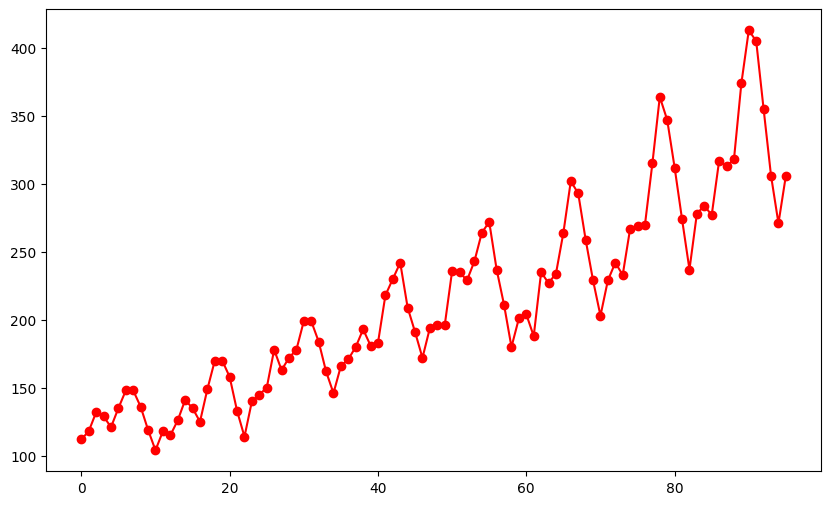

In [15]:
airline['Passengers'].plot(marker='o',color='red',figsize=(10,6))
plt.show()

We can see that there is an increasing Trend. So, Trend is not constant.

Variance is also not constant.

Hence the time series is not stationary.


<Axes: xlabel='year', ylabel='Passengers'>

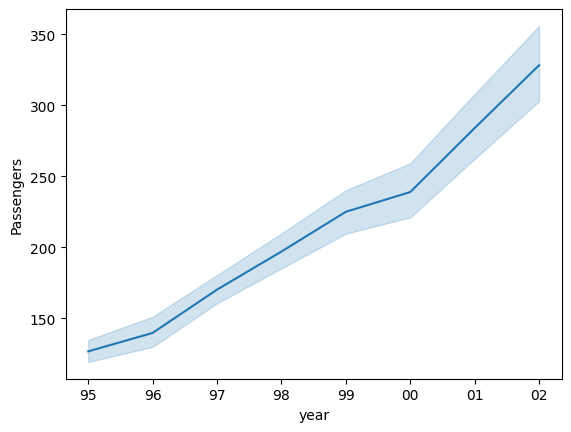

In [16]:
sns.lineplot(x='year',y='Passengers',data=airline)

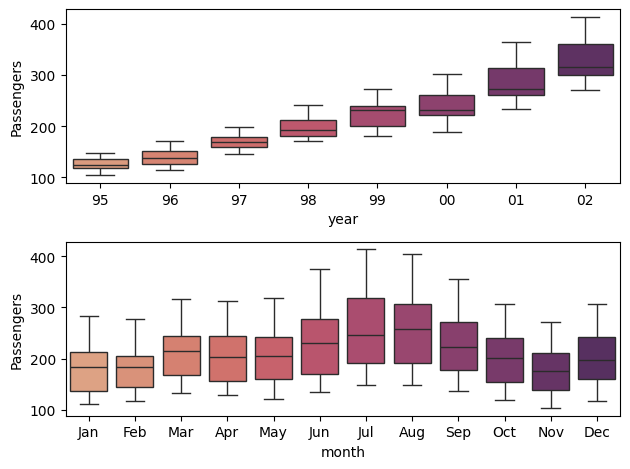

In [17]:
plt.subplot(211)
sns.boxplot(x='year',y='Passengers',data=airline,palette='flare')
plt.subplot(212)
sns.boxplot(x='month',y='Passengers',data=airline,palette='flare')
plt.tight_layout()
plt.show()

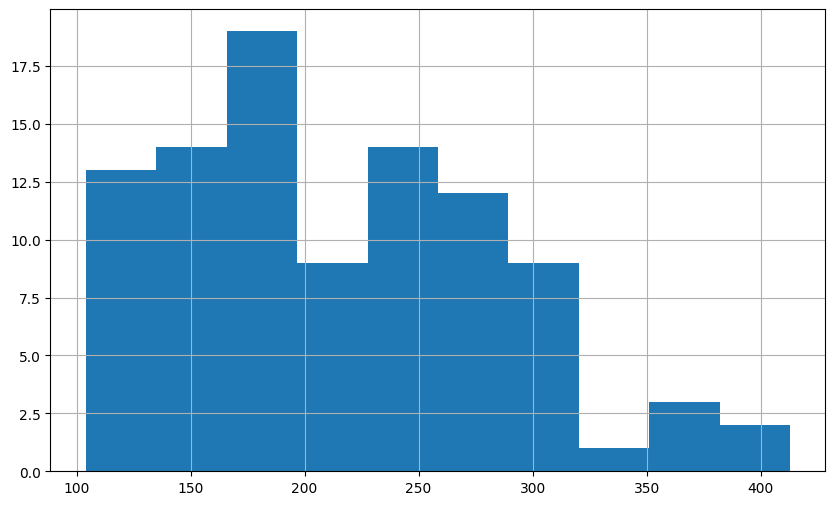

In [18]:
airline.Passengers.hist(figsize=(10,6))
plt.show()

**a)LagPlot**

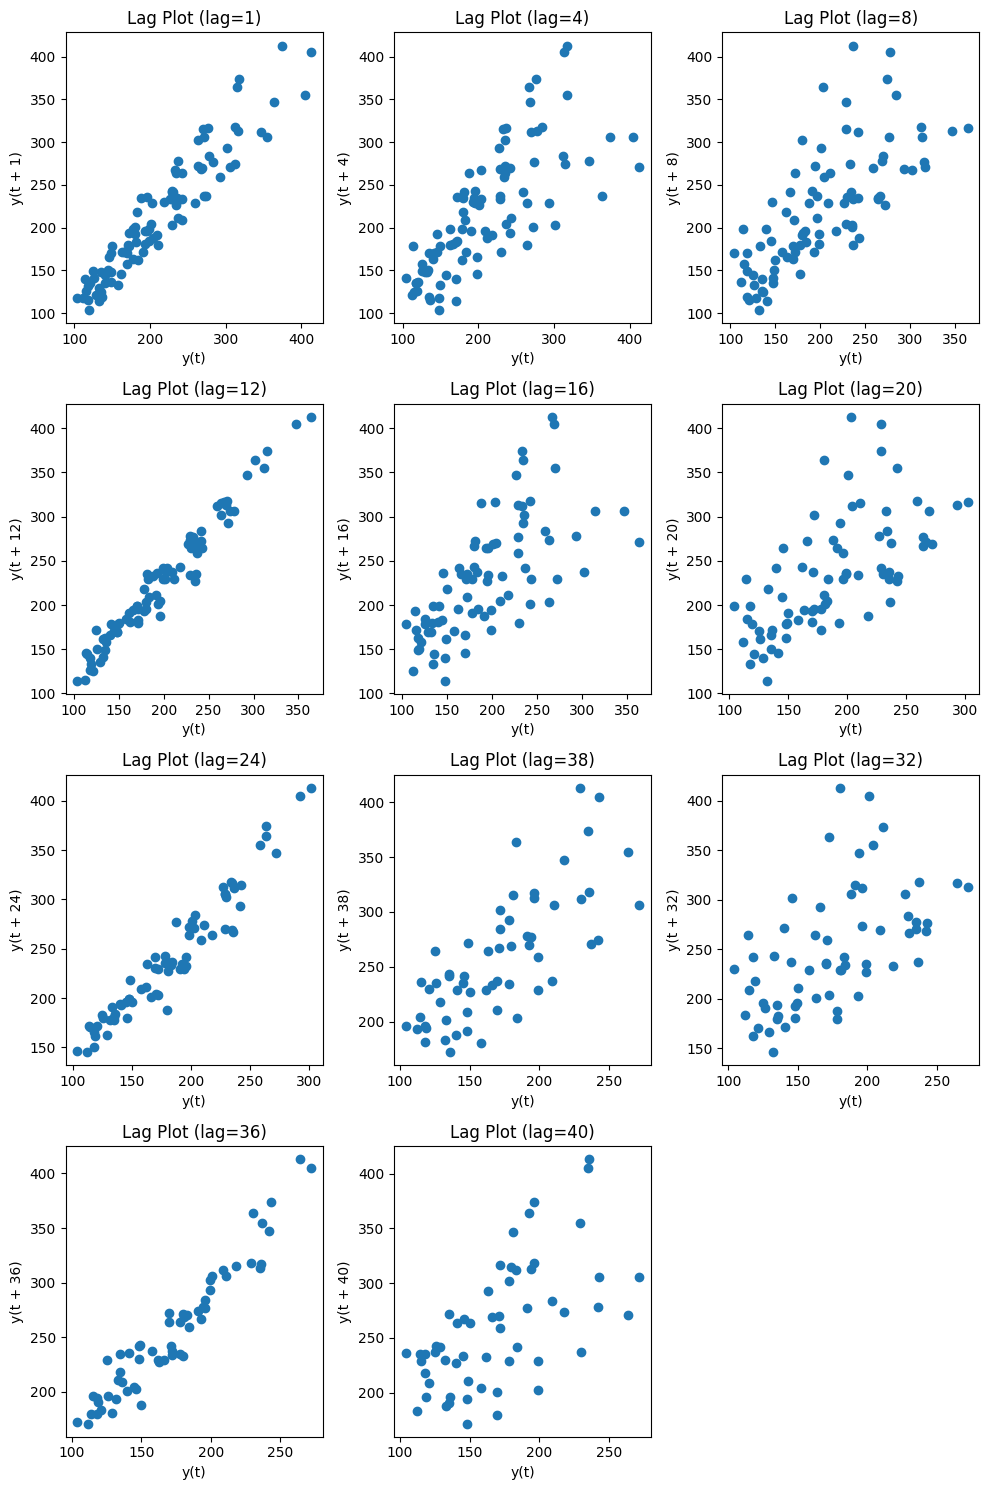

In [19]:
lag_values=[1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]
plt.figure(figsize=(10, 15))
for i,lag in enumerate(lag_values,start=1):
  plt.subplot(4,3,i)
  lag_plot(airline.Passengers,lag=lag)
  plt.title(f"Lag Plot (lag={lag})")

plt.tight_layout()
plt.show()

 **b)Moving Average**

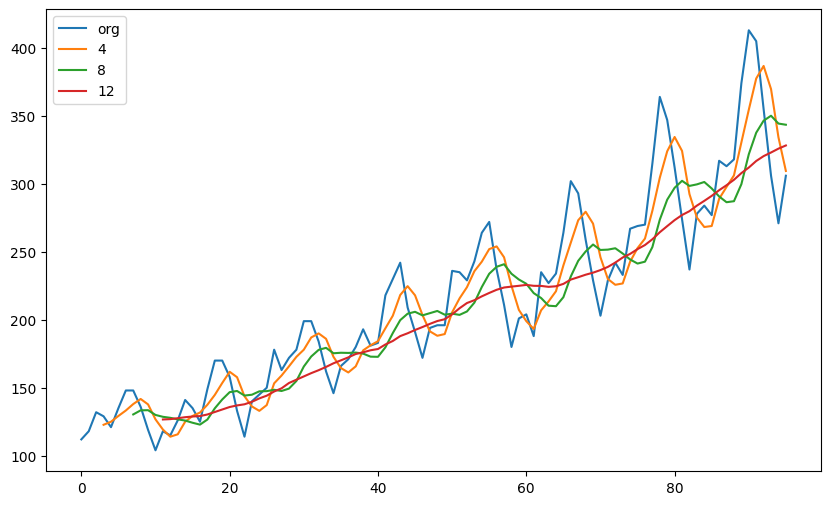

In [20]:
plt.figure(figsize=(10,6))
airline.Passengers.plot(label='org')
for i in range(4,13,4):
  airline['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.show()

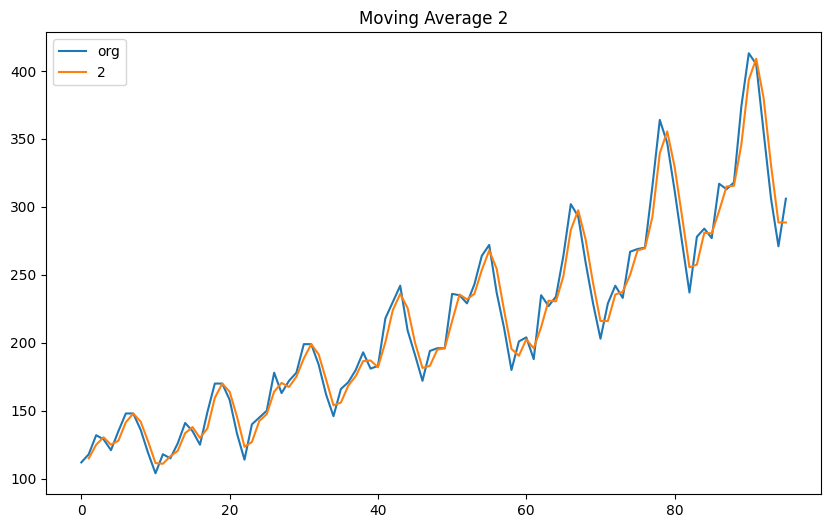

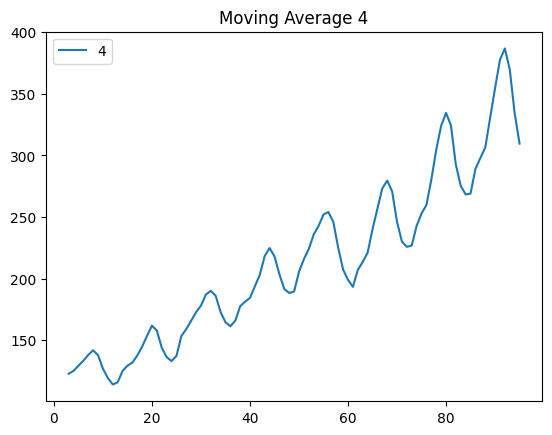

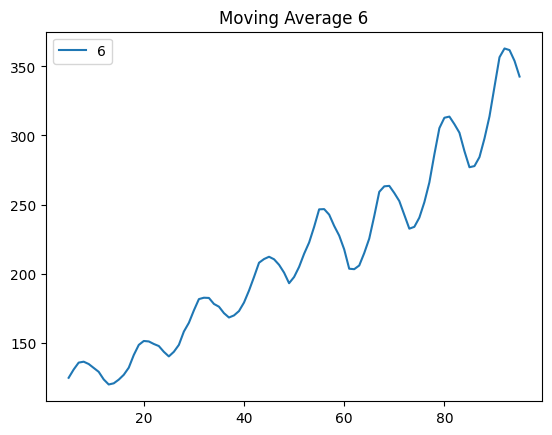

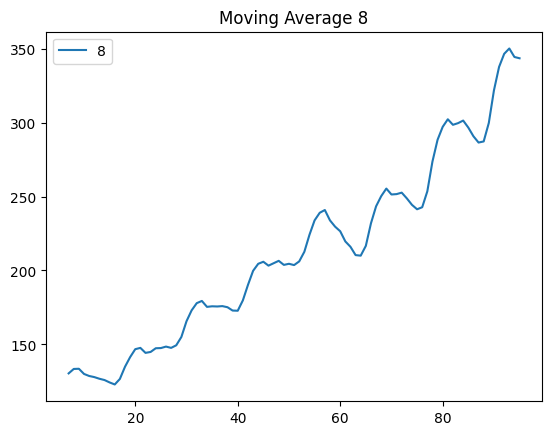

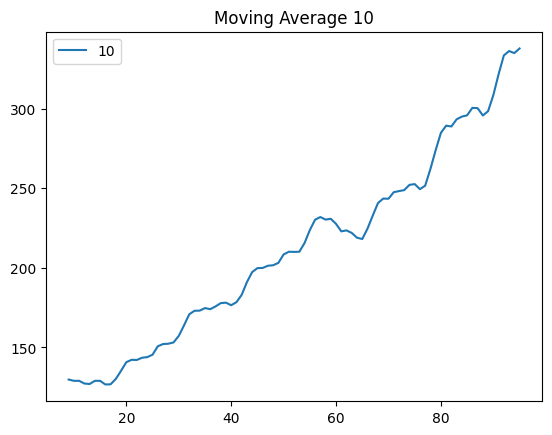

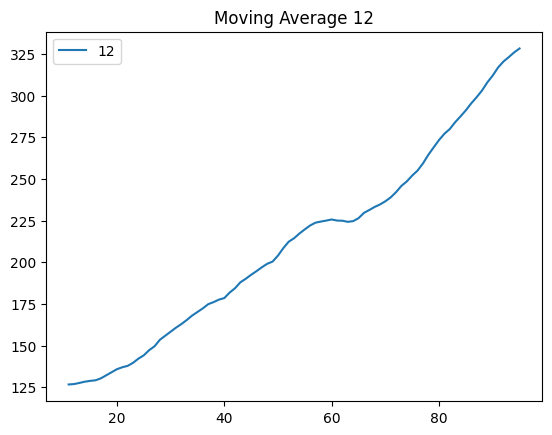

In [21]:
plt.figure(figsize=(10,6))
airline.Passengers.plot(label='org')
plt.title('Orginal Series')
for i in range(2,13,2):
  airline['Passengers'].rolling(i).mean().plot(label=str(i))
  plt.title("Moving Average "+str(i))
  plt.legend(loc='best')
  plt.show()

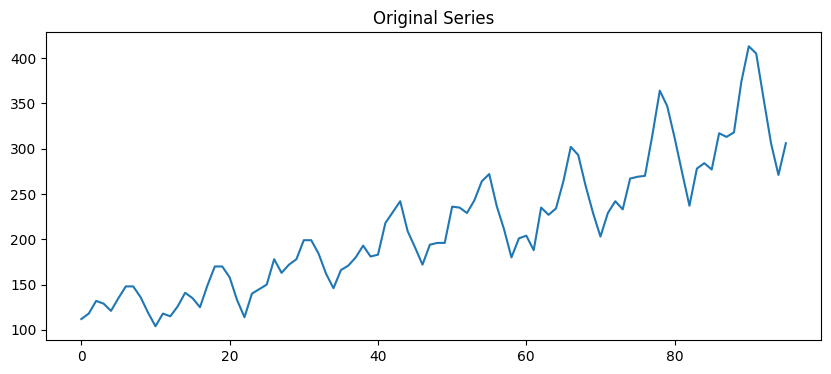

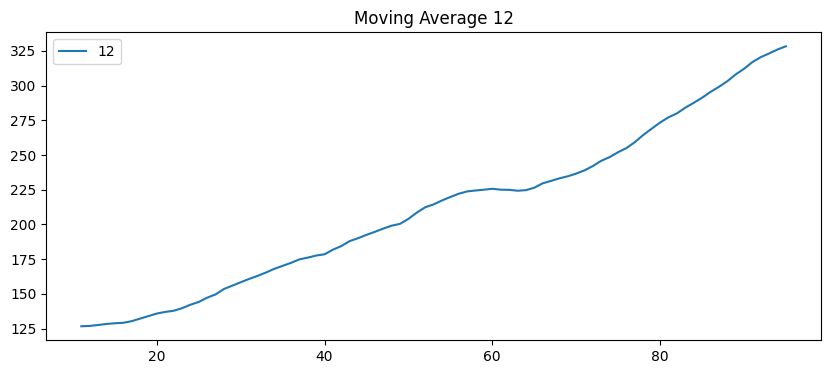

In [22]:
plt.figure(figsize=(10,4))
airline.Passengers.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(10,4))
airline["Passengers"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

**c)Time series decomposition plot**

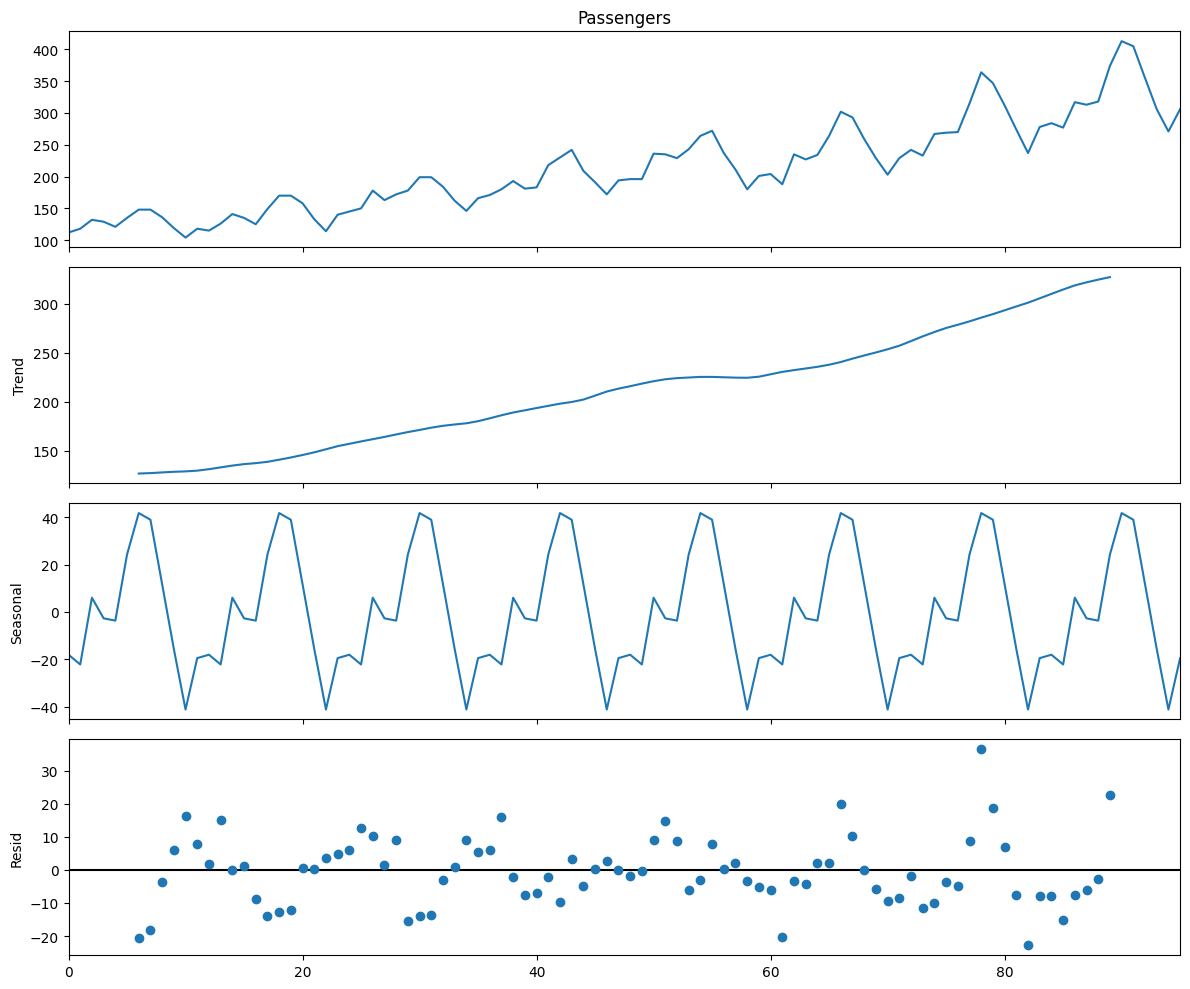

In [23]:
decompose_tsp= seasonal_decompose(airline.Passengers,period=12)
with plt.rc_context():
  plt.rc('figure',figsize=(12,10))
  decompose_tsp.plot()
  plt.show()

# **ACF plots and PACF plots**

a)Autocorrelation Function (ACF)

b)Partial Autocorrelation Function (PACF)



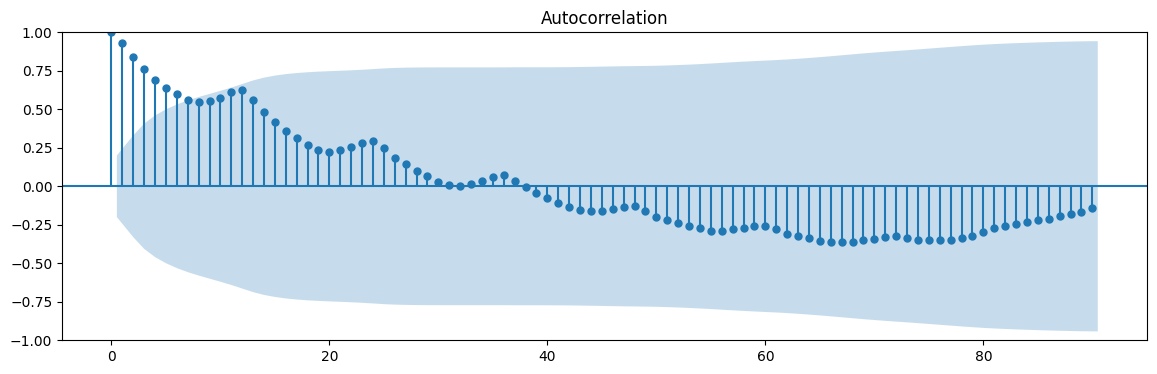

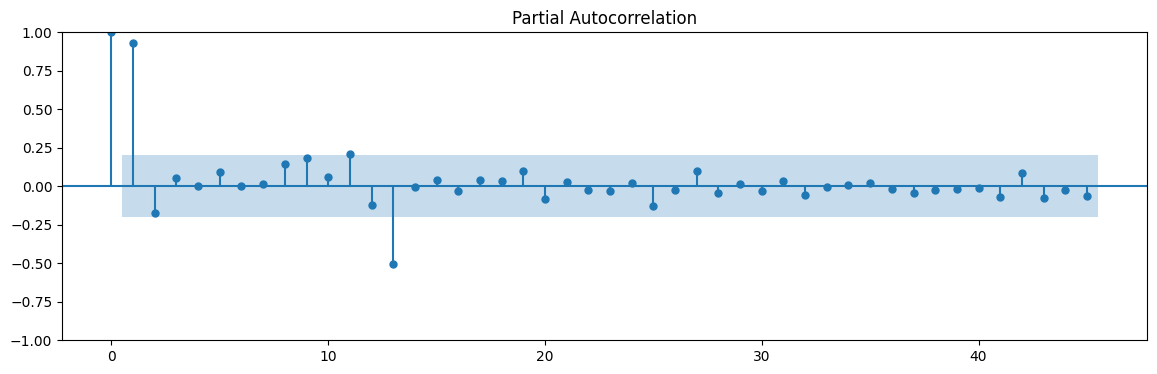

In [24]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
  plt.rc("figure",figsize=(14,4))
  tsa_plots.plot_acf(airline.Passengers,lags=90)
  tsa_plots.plot_pacf(airline.Passengers,lags=45)
  plt.show()

Additive Seasonal Decomposition

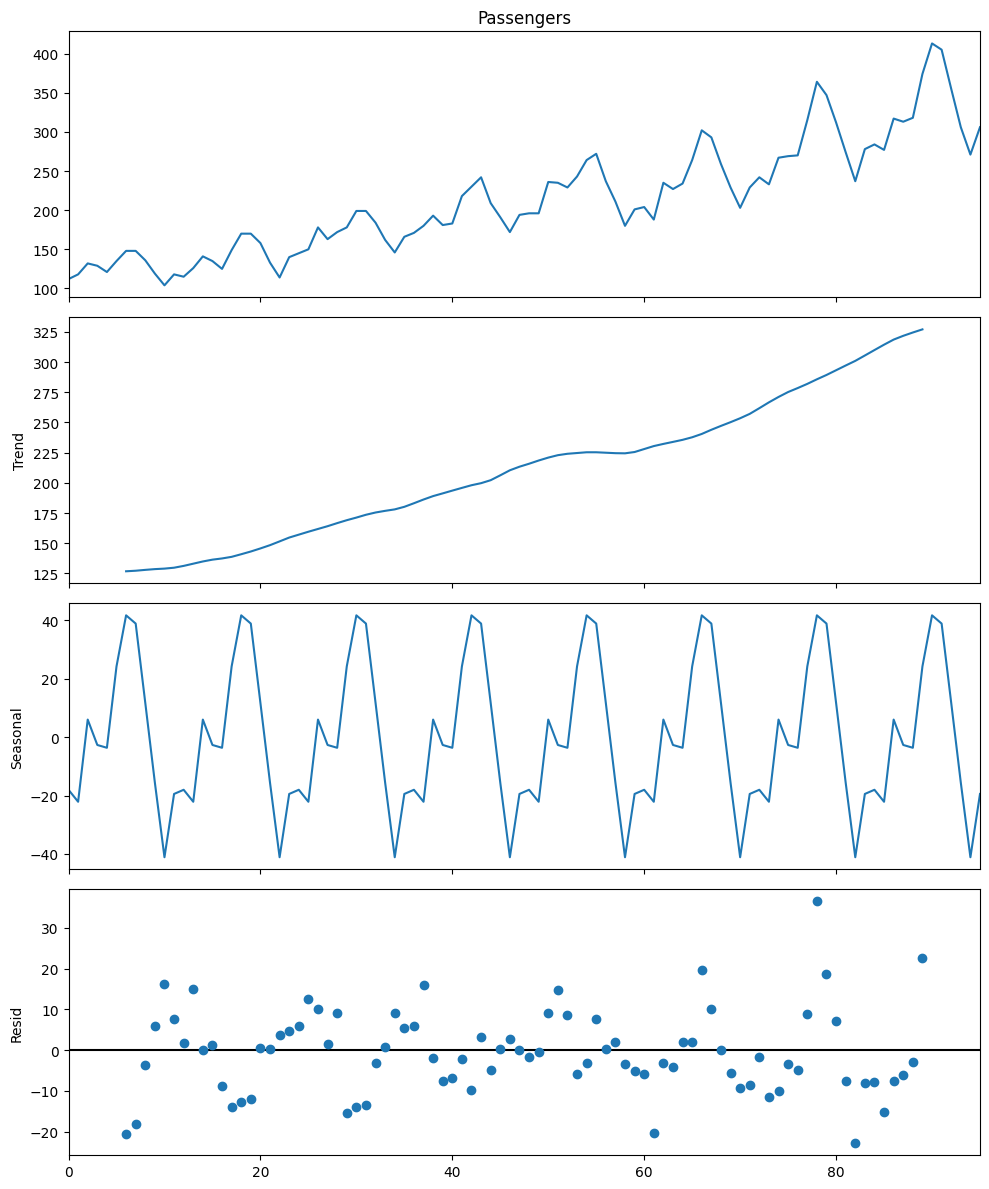

In [25]:
decompose_tsp= seasonal_decompose(airline.Passengers,period=12,model='additive')
with plt.rc_context():
  plt.rc('figure',figsize=(10,12))
  decompose_tsp.plot()
  plt.show()

Multiplicative Seasonal Decomposition


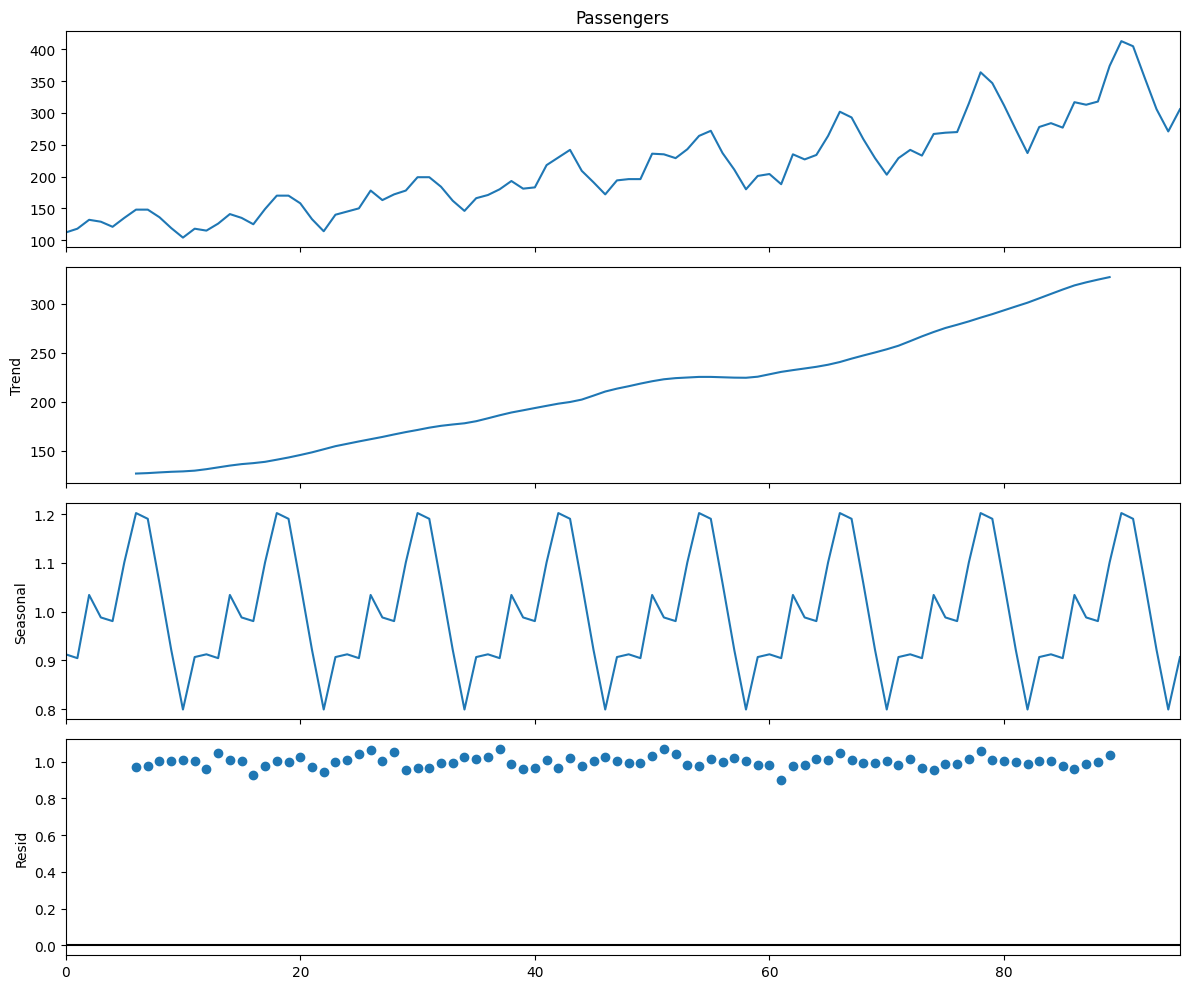

In [26]:
decompose_tsp= seasonal_decompose(airline.Passengers,period=12,model='multiplicative')
with plt.rc_context():
  plt.rc('figure',figsize=(12,10))
  decompose_tsp.plot()
  plt.show()

# **Splitting Train and Test Data**

In [27]:
train=airline1[:72]
test= airline1[72:]

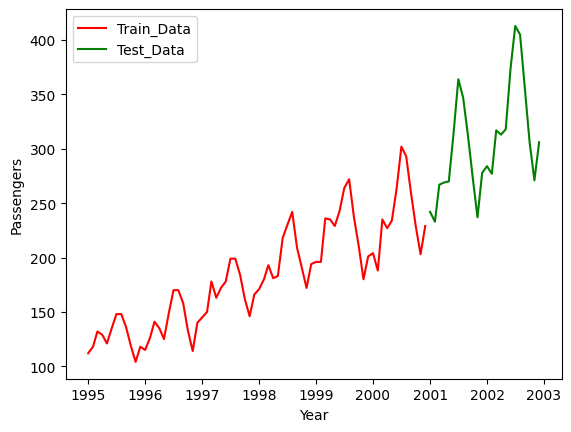

In [28]:
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.plot(train,'red',label='Train_Data')
plt.plot(test,'green',label='Test_Data')
plt.legend()
plt.show()

In [29]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# **Exponential Methods**

a)Simple Exponential Method


In [30]:
sem_model= SimpleExpSmoothing(train["Passengers"]).fit(optimized=True)
test_pred_sem=sem_model.forecast(24)
train_pred_sem= sem_model.fittedvalues
test_rmse_sem=sqrt(mean_squared_error(test_pred_sem,test.Passengers))
train_rmse_sem=sqrt(mean_squared_error(train_pred_sem,train))
mape_sem=MAPE(test_pred_sem,test.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_sem),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_sem),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_sem))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 23.38228335004472 
 Train Root Mean Squared Error = 19.031771730910982 
 Test Root Mean Squared Error  = 91.11325402904403


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


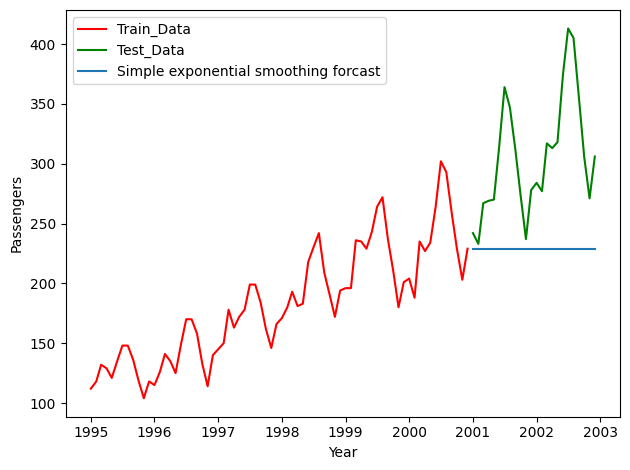

In [31]:
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.plot(train,'red',label='Train_Data')
plt.plot(test,'green',label='Test_Data')
plt.plot(test_pred_sem,label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

b)Holt method (Double Exponential)

In [32]:
holt_model= Holt(train,initialization_method="estimated").fit(optimized=True)
test_pred_holt=holt_model.forecast(24)
train_pred_holt= holt_model.fittedvalues
test_rmse_holt=sqrt(mean_squared_error(test_pred_holt,test.Passengers))
train_rmse_holt=sqrt(mean_squared_error(train_pred_holt,train))
mape_holt=MAPE(test_pred_holt,test.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_holt),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_holt),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_holt))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 17.193743093876254 
 Train Root Mean Squared Error = 18.961319080771776 
 Test Root Mean Squared Error  = 71.77202787637248


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


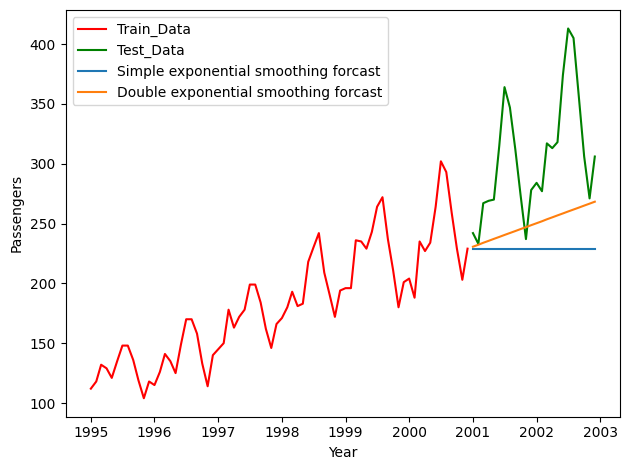

In [33]:
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.plot(train,'red',label='Train_Data')
plt.plot(test,'green',label='Test_Data')
plt.plot(test_pred_sem,label='Simple exponential smoothing forcast')
plt.plot(test_pred_holt,label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

 We are able to capture the trend of the data but not the seasonality

c)Holts winter exponential smoothing with additive seasonality

In [34]:
holt_wmodel= ExponentialSmoothing(train,seasonal='add',trend='add',seasonal_periods=12,initialization_method="estimated").fit(optimized=True)
test_pred_wholt=holt_wmodel.forecast(24)
train_pred_wholt= holt_wmodel.fittedvalues
test_rmse_wholt=sqrt(mean_squared_error(test_pred_wholt,test.Passengers))
train_rmse_wholt=sqrt(mean_squared_error(train_pred_wholt,train))
mape_wholt=MAPE(test_pred_wholt,test.Passengers)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_wholt),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_wholt),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_wholt))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error   = 12.084813658780355 
 Train Root Mean Squared Error = 7.751303513604031 
 Test Root Mean Squared Error  = 47.570269203462864


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


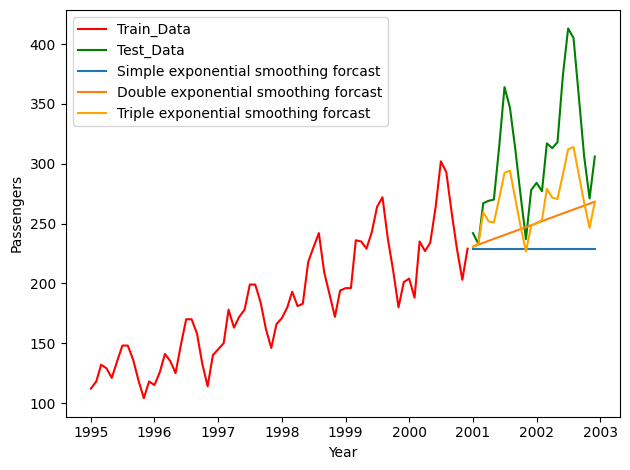

In [35]:
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.plot(train,'red',label='Train_Data')
plt.plot(test,'green',label='Test_Data')
plt.plot(test_pred_sem,label='Simple exponential smoothing forcast')
plt.plot(test_pred_holt,label='Double exponential smoothing forcast')
plt.plot(test_pred_wholt,'orange',label='Triple exponential smoothing forcast')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

It captures the trend, which we can see that the forecasted values are lower level than the test level.

It also captures the seasonality.

d)Holts winter exponential smoothing with multiplicative seasonality

In [36]:
holt_wmodel_mul= ExponentialSmoothing(train,seasonal='mul',trend='add',seasonal_periods=12).fit(optimized=True)
test_pred_wholt_mul=holt_wmodel_mul.forecast(24)
train_pred_wholt_mul= holt_wmodel_mul.fittedvalues
test_rmse_wholt_mul=sqrt(mean_squared_error(test_pred_wholt_mul,test.Passengers))
train_rmse_wholt_mul=sqrt(mean_squared_error(train_pred_wholt_mul,train))
mape_wholt_mul=MAPE(test_pred_wholt_mul,test.Passengers)
print('Triple Exponential Method with Multiplicative Seasonality',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_wholt_mul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_wholt_mul),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_wholt_mul))

Triple Exponential Method with Multiplicative Seasonality 
 Mean Absolute Percent Error   = 9.368409298996491 
 Train Root Mean Squared Error = 6.386634437268093 
 Test Root Mean Squared Error  = 34.98955392874329


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


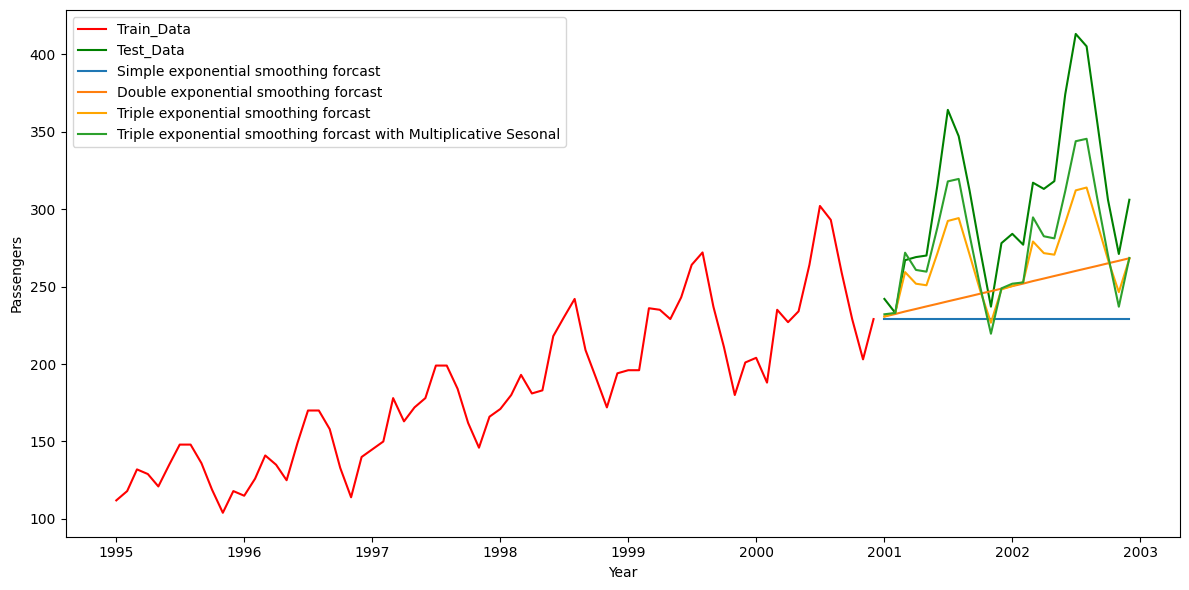

In [37]:
plt.figure(figsize=(12,6))
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.plot(train,'red',label='Train_Data')
plt.plot(test,'green',label='Test_Data')
plt.plot(test_pred_sem,label='Simple exponential smoothing forcast')
plt.plot(test_pred_holt,label='Double exponential smoothing forcast')
plt.plot(test_pred_wholt,'orange',label='Triple exponential smoothing forcast')
plt.plot(test_pred_wholt_mul,label='Triple exponential smoothing forcast with Multiplicative Sesonal')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

e)Holts winter exponential smoothing with Additive seasonality and multiplicative trend

In [38]:
holt_wmodel_t= ExponentialSmoothing(train,seasonal='add',trend='mul',seasonal_periods=12,initialization_method="estimated").fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_wholt_t=holt_wmodel_t.forecast(24)
train_pred_wholt_t= holt_wmodel_t.fittedvalues
test_rmse_wholt_t=sqrt(mean_squared_error(test_pred_wholt_t,test.Passengers))
train_rmse_wholt_t=sqrt(mean_squared_error(train_pred_wholt_t,train))
mape_wholt_t=MAPE(test_pred_wholt_t,test.Passengers)
print('Triple Exponential with Multiplicative Trend and Additive Seosonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_wholt_t),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_wholt_t),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_wholt_t))

Triple Exponential with Multiplicative Trend and Additive Seosonality Method Evaluation 
 Mean Absolute Percent Error   = 13.341866948862238 
 Train Root Mean Squared Error = 12.755539751240624 
 Test Root Mean Squared Error  = 48.34208410593296


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


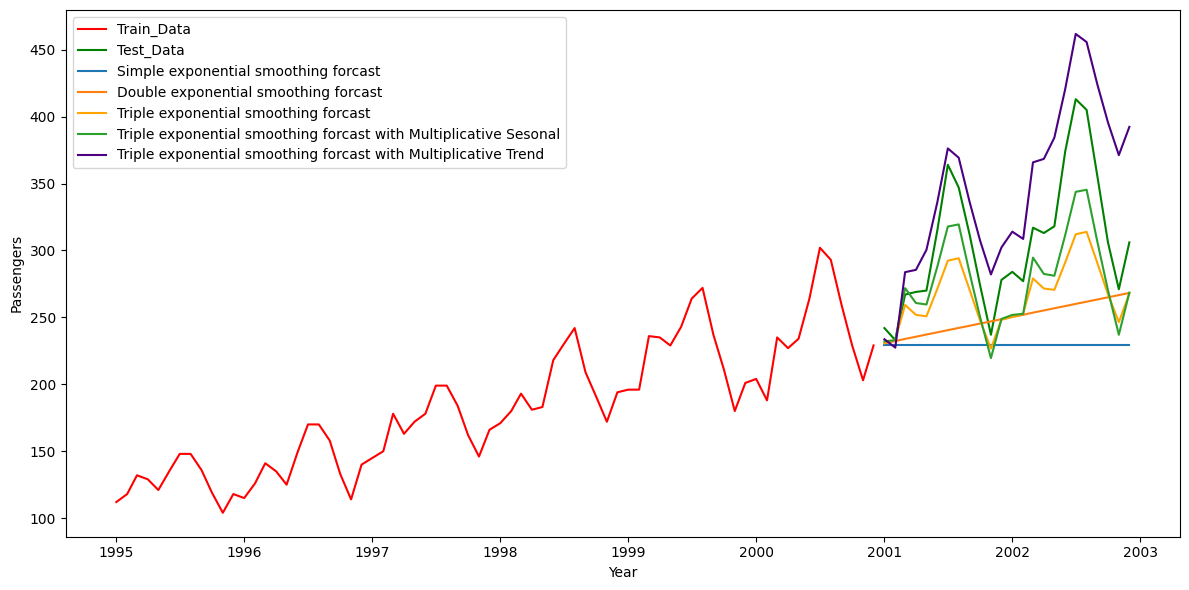

In [39]:
plt.figure(figsize=(12,6))
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.plot(train,'red',label='Train_Data')
plt.plot(test,'green',label='Test_Data')
plt.plot(test_pred_sem,label='Simple exponential smoothing forcast')
plt.plot(test_pred_holt,label='Double exponential smoothing forcast')
plt.plot(test_pred_wholt,'orange',label='Triple exponential smoothing forcast')
plt.plot(test_pred_wholt_mul,label='Triple exponential smoothing forcast with Multiplicative Sesonal')
plt.plot(test_pred_wholt_t,"indigo",label='Triple exponential smoothing forcast with Multiplicative Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

f)Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend

In [40]:
holt_wmodel_ts= ExponentialSmoothing(train,seasonal='mul',trend='mul',seasonal_periods=12,initialization_method="estimated").fit(optimized=True)
test_pred_wholt_ts=holt_wmodel_ts.forecast(24)
train_pred_wholt_ts= holt_wmodel_ts.fittedvalues
test_rmse_wholt_ts=sqrt(mean_squared_error(test_pred_wholt_ts,test.Passengers))
train_rmse_wholt_ts=sqrt(mean_squared_error(train_pred_wholt_ts,train))
mape_wholt_ts=MAPE(test_pred_wholt_ts,test.Passengers)
print('Triple Exponential with Multiplicative Trend and Multiplicative Seosonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_wholt_ts),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_wholt_ts),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_wholt_ts))

Triple Exponential with Multiplicative Trend and Multiplicative Seosonality Method Evaluation 
 Mean Absolute Percent Error   = 6.035078693970935 
 Train Root Mean Squared Error = 6.396749786818969 
 Test Root Mean Squared Error  = 23.058842144878668


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


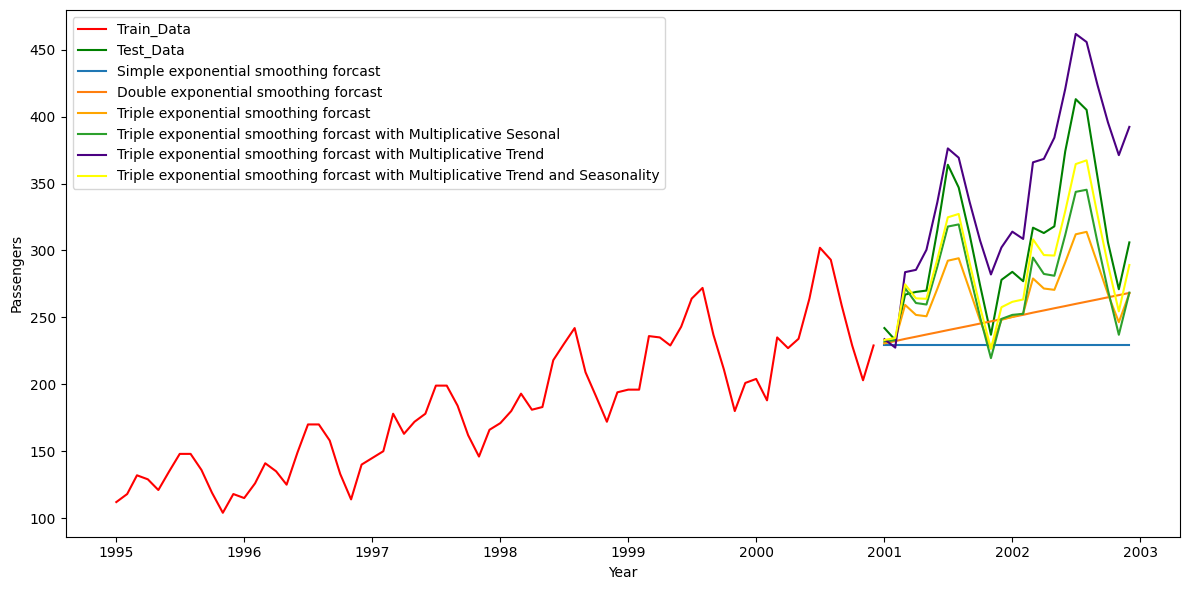

In [41]:
plt.figure(figsize=(12,6))
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.plot(train,'red',label='Train_Data')
plt.plot(test,'green',label='Test_Data')
plt.plot(test_pred_sem,label='Simple exponential smoothing forcast')
plt.plot(test_pred_holt,label='Double exponential smoothing forcast')
plt.plot(test_pred_wholt,'orange',label='Triple exponential smoothing forcast')
plt.plot(test_pred_wholt_mul,label='Triple exponential smoothing forcast with Multiplicative Sesonal')
plt.plot(test_pred_wholt_t,"indigo",label='Triple exponential smoothing forcast with Multiplicative Trend')
plt.plot(test_pred_wholt_ts,"yellow",label='Triple exponential smoothing forcast with Multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# **Comparing the results**

In [42]:
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_Add","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Mul"]),
        "Train_RMSE":pd.Series([train_rmse_sem,train_rmse_holt,train_rmse_wholt,train_rmse_wholt_mul,train_rmse_wholt_t,train_rmse_wholt_ts]),
        "Test_MAPE(%)":pd.Series([mape_sem,mape_holt,mape_wholt,mape_wholt_mul,mape_wholt_t,mape_wholt_ts]),
        "Test_RMSE_Values":pd.Series([test_rmse_sem,test_rmse_holt,test_rmse_wholt,test_rmse_wholt_mul,test_rmse_wholt_t,test_rmse_wholt_ts])}
table_evaluation = pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_Mul,6.396750,6.035079,23.058842
1,Triple_Exp_Mul_Add,6.386634,9.368409,34.989554
2,Triple_Exp_Add,7.751304,12.084814,47.570269
3,Triple_Exp_Add_Mul,12.755540,13.341867,48.342084
4,Double_Exp,18.961319,17.193743,71.772028
5,Simple_Exp,19.031772,23.382283,91.113254


<Axes: xlabel='Test_RMSE_Values', ylabel='Models'>

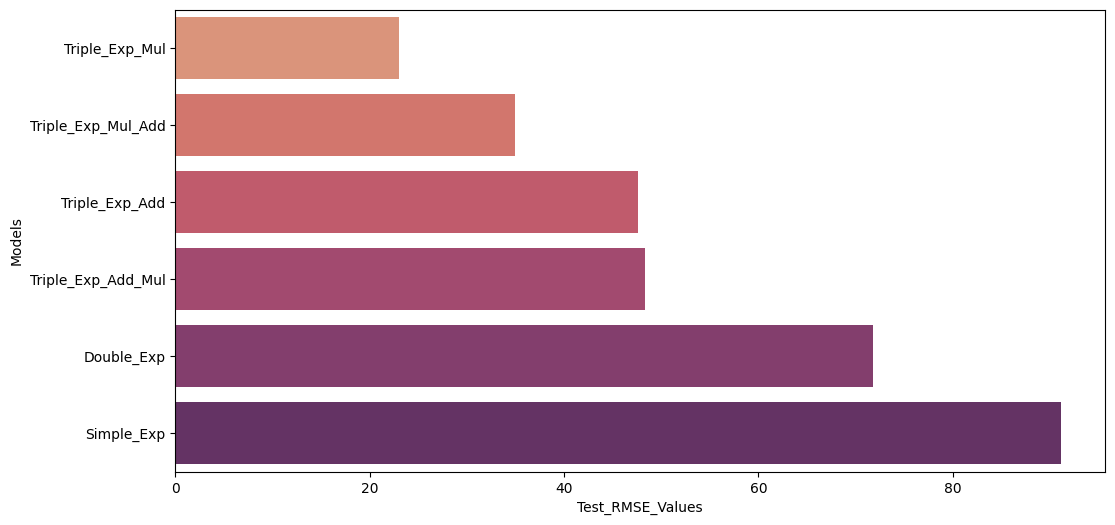

In [43]:
f, axe = plt.subplots(1,1, figsize=(12,6))
sns.barplot(x= 'Test_RMSE_Values', y= 'Models', data= table_evaluation, ax= axe,palette='flare')

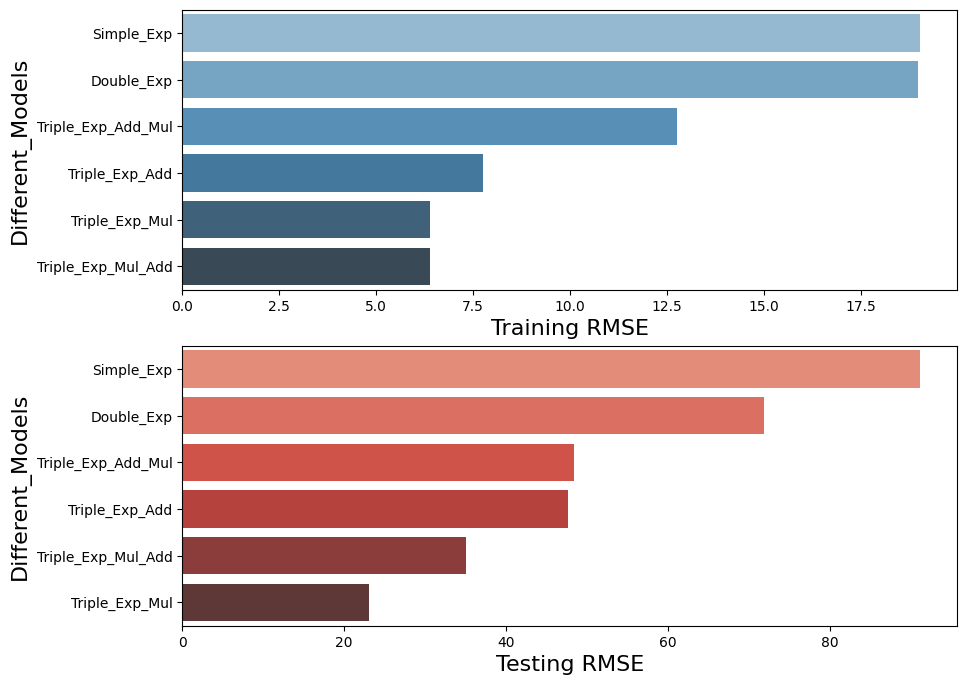

In [44]:
f, axes = plt.subplots(2,1, figsize=(10,8))
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models', size=16)

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models', size=16)

plt.show()

# **Autoregressive Integrated Moving Averages (ARIMA)**

In [45]:
def test_stationarity(timeseries):

    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

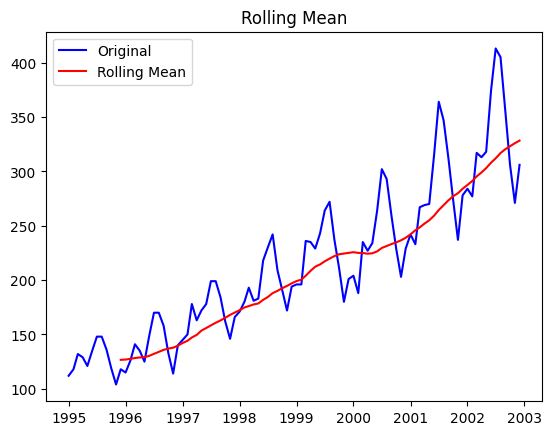

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [46]:
sales= pd.DataFrame()
sales['Passengers'] = airline1[['Passengers']]
test_stationarity(sales)

In [47]:
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [48]:
adf_test(sales)

Fail to reject the null hypothesis
Data is non-stationary


# **Converting Non-Stationary Time Series into Stationary**

a)Differencing

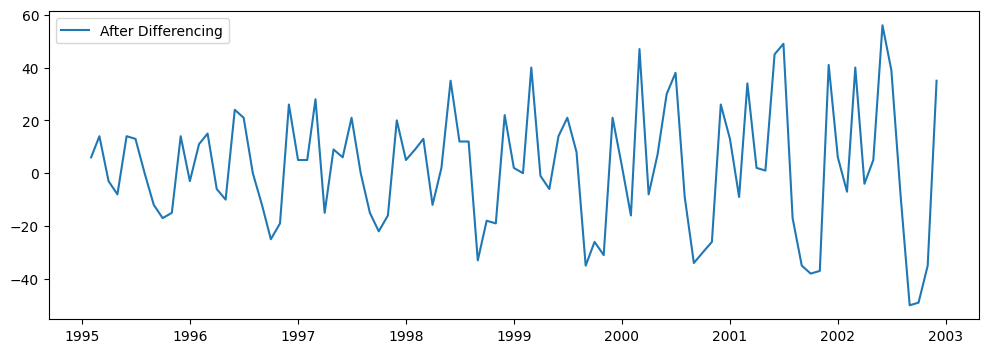

In [49]:
differencing = airline1 - airline1.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

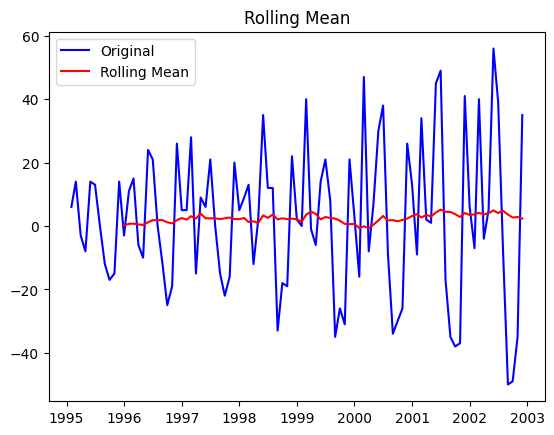

Results of Dickey Fuller Test:
Test Statistic                 -2.150002
p-value                         0.224889
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [50]:
test_stationarity(differencing)

In [51]:
adf_test(differencing)

Fail to reject the null hypothesis
Data is non-stationary


b)Seasonal Differencing

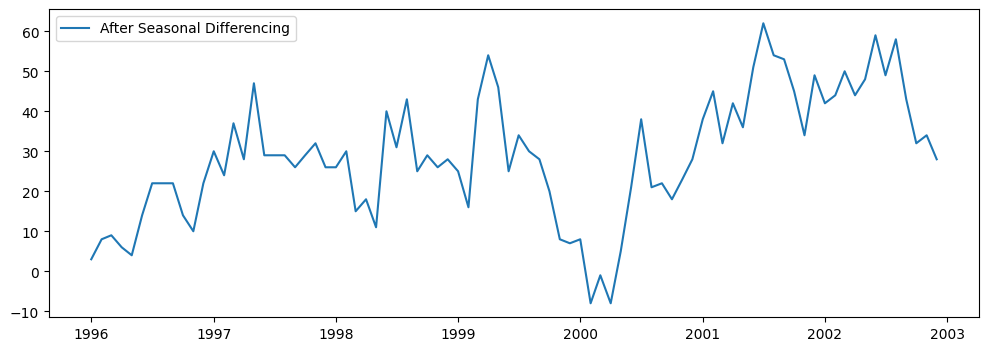

In [52]:
seasonal_differencing = airline1 - airline1.shift(12)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

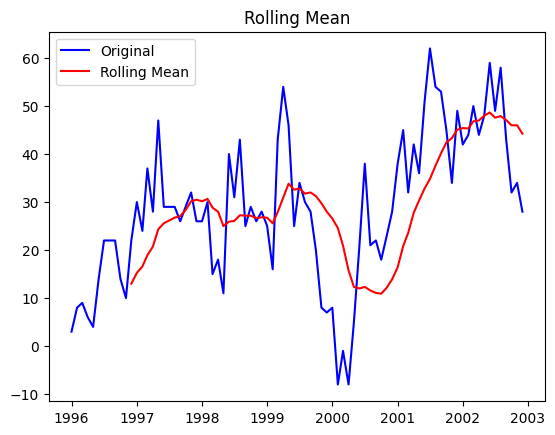

Results of Dickey Fuller Test:
Test Statistic                 -2.690004
p-value                         0.075784
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [53]:
test_stationarity(seasonal_differencing)

In [54]:
adf_test(seasonal_differencing)

Fail to reject the null hypothesis
Data is non-stationary


# **Box Cox Transformation**

,Passengers
Date,
1995-01-01,4.718499
1995-02-01,4.770685
1995-03-01,4.882802
1995-04-01,4.859812
1995-05-01,4.795791


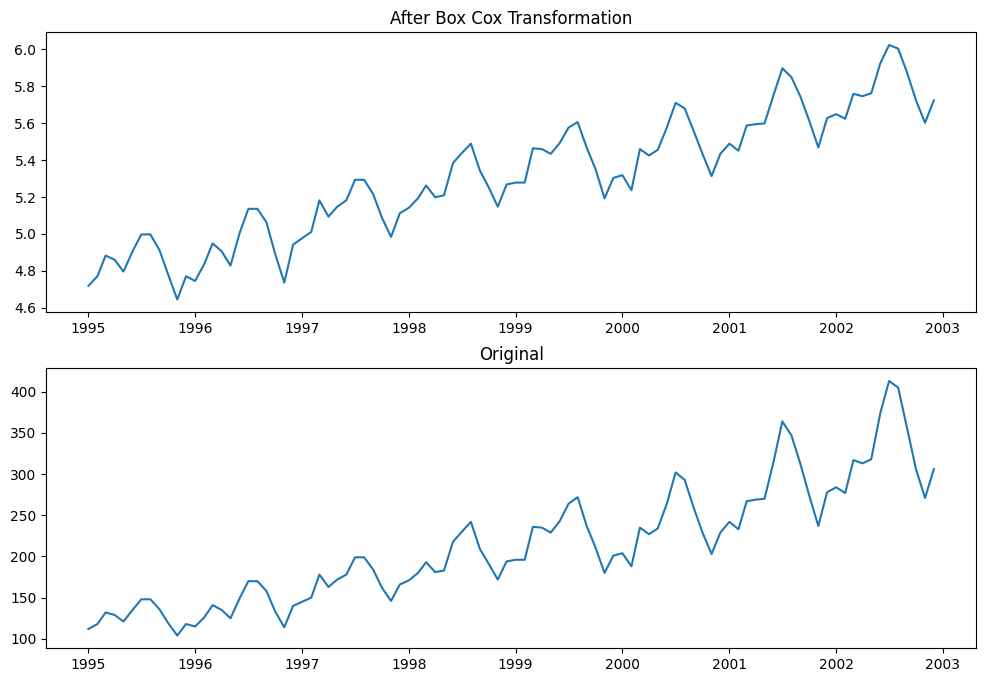

In [55]:
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(airline1['Passengers'], lmbda=0), airline1.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(12,8),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(airline1, label='original')
axis[1].set_title('Original')
plt.show()

The variance became almost constant after the transformation.

The series has an upward trend.So, the mean is not constant yet

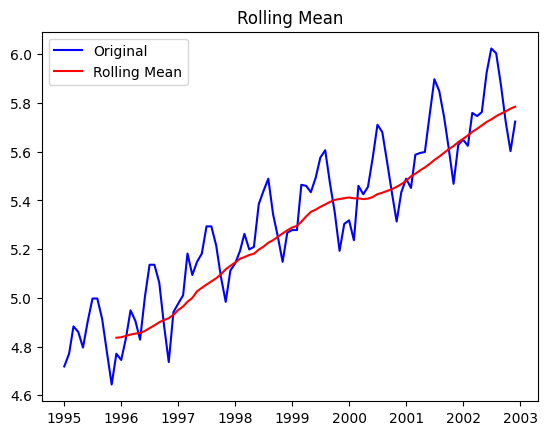

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [56]:
test_stationarity(data_boxcox)

In [57]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


Differencing of the Box-Cox Transformation

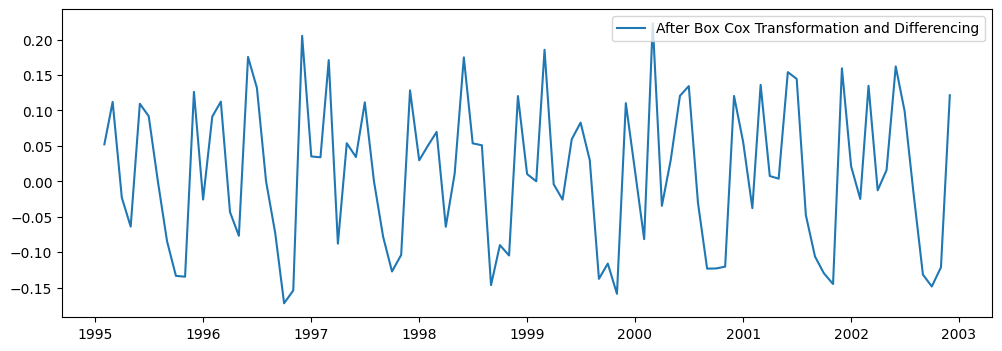

In [58]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

We can see that there is no trend after differencing on the Box Cox transformation.

It is a horizontal trend.

The mean became constant. The mean is zero.
Also, the variance is almost constant.

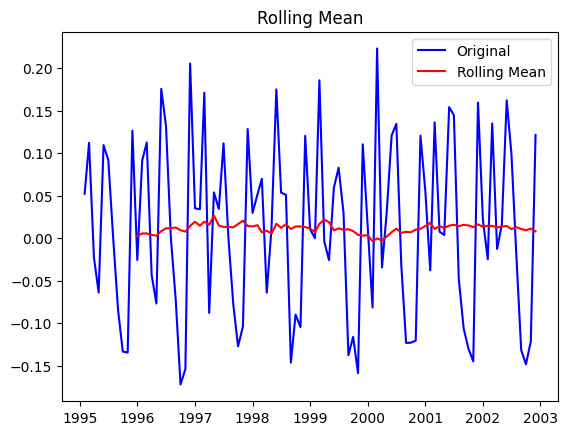

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [59]:
test_stationarity(data_boxcox_diff)

In [60]:
adf_test(data_boxcox_diff)

Fail to reject the null hypothesis
Data is non-stationary


# **Building The Time Series Forecasting with Optimal Value using ARIMA**

In [61]:
train_data_boxcox = data_boxcox[:72]
test_data_boxcox = data_boxcox[72:]
train_data_boxcox_diff = data_boxcox_diff[:72]
test_data_boxcox_diff = data_boxcox_diff[72:]

# ARIMA Hyperparameter Tuning

In [77]:
def evaluate_arima_model(X, arima_order):

# Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

# Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

# Calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                      if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [80]:
p_values = range(0,5)
d_values = range(0,5)
q_values = range(0,5)
evaluate_models(train_data_boxcox_diff.Passengers, p_values, d_values, q_values)

Best ARIMA(4, 1, 4) RMSE=0.090


# Inverse transformation of the Box-Cox Differencing

In [81]:
model = ARIMA(train_data_boxcox_diff, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

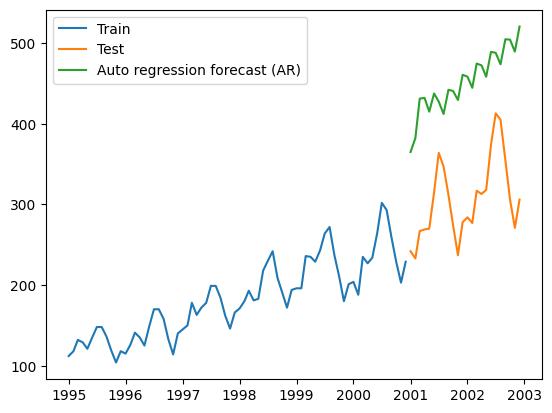

In [83]:
plt.plot(train['Passengers'], label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

No Seasonality captured. Only Trend has been captured

# **Model Evaluation**

In [84]:
rmse_arima = np.sqrt(mean_squared_error(test, y_hat_ar['arima_forecast'][test.index.min():])).round(2)
rmse_arima

152.57

In [85]:
mape_arima = round(np.mean(np.abs((test.Passengers - y_hat_ar['arima_forecast'][test.index.min():])/test.Passengers)*100),2)
mape_arima

50.27

# Analysing the Residuals

In [86]:
model_residual = model_fit.resid
model_residual.mean()

-0.005710683617502512

In [87]:
adf_test(model_residual)

Fail to reject the null hypothesis
Data is non-stationary


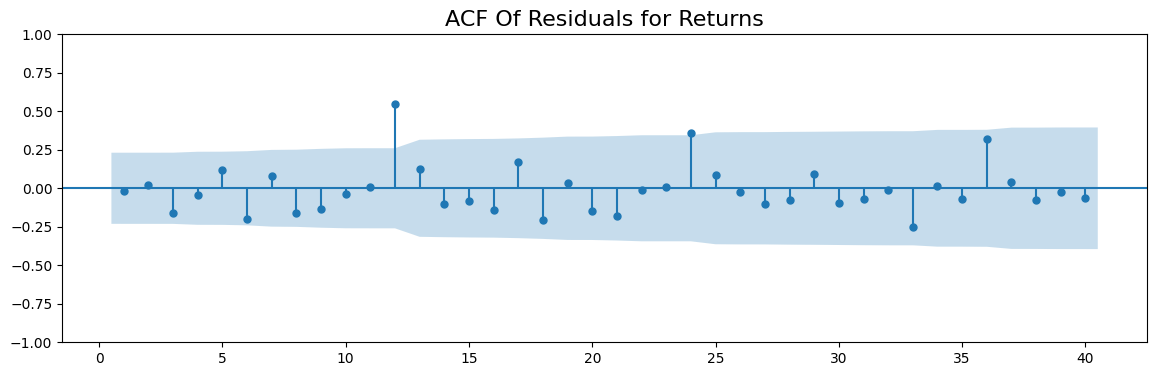

In [89]:
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=16)
plt.show()

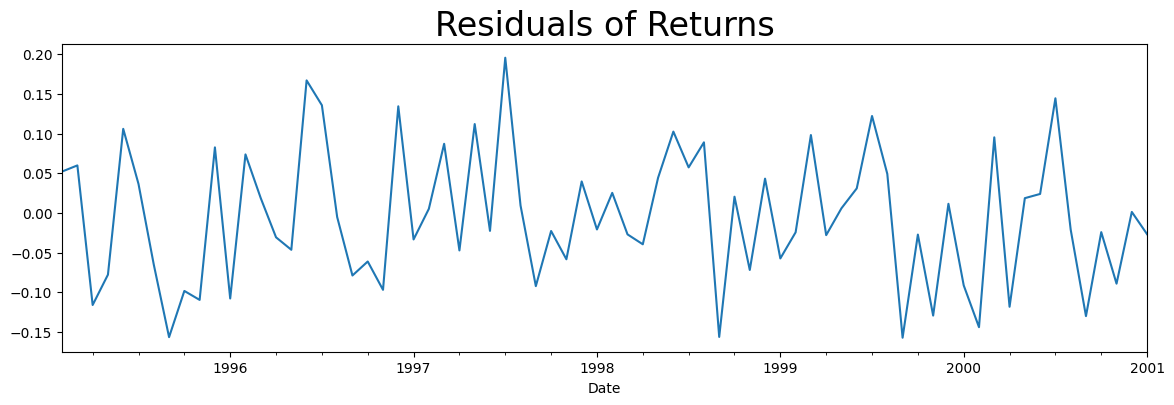

In [90]:
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

# **Creating model with differente Transformation Technique**

In [92]:
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_Add","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Mul","ARIMA"]),
        "MAPE(%)":pd.Series([mape_sem,mape_holt,mape_wholt,mape_wholt_mul,mape_wholt_t,mape_wholt_ts,mape_arima]),
        "RMSE_Values":pd.Series([test_rmse_sem,test_rmse_holt,test_rmse_wholt,test_rmse_wholt_mul,test_rmse_wholt_t,test_rmse_wholt_ts,rmse_arima])}
table_evaluation = pd.DataFrame(Evaluation)
table_evaluation.sort_values(['MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,MAPE(%),RMSE_Values
0,Triple_Exp_Mul,6.035079,23.058842
1,Triple_Exp_Mul_Add,9.368409,34.989554
2,Triple_Exp_Add,12.084814,47.570269
3,Triple_Exp_Add_Mul,13.341867,48.342084
4,Double_Exp,17.193743,71.772028
5,Simple_Exp,23.382283,91.113254
6,ARIMA,50.270000,152.570000


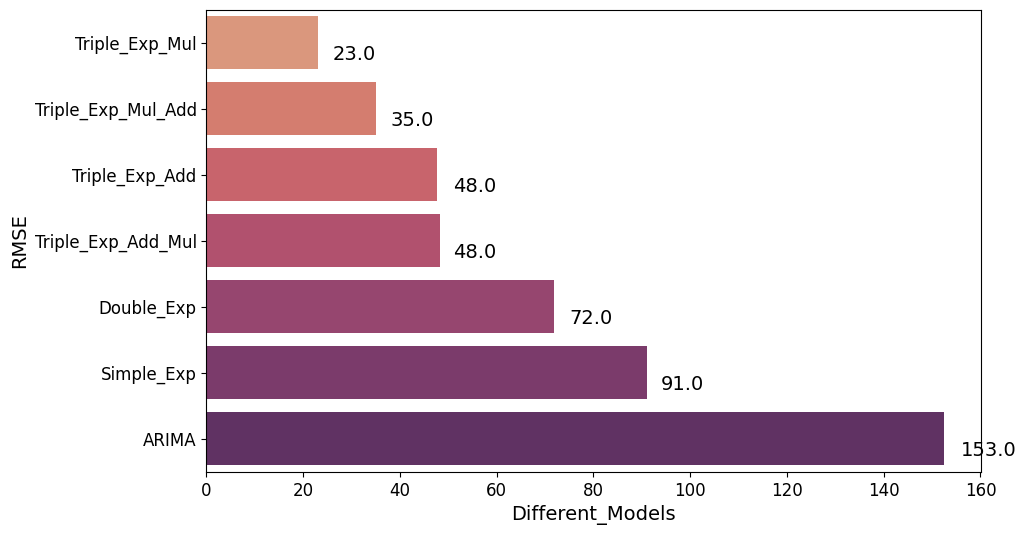

In [97]:
f, axe = plt.subplots(1,1, figsize=(10,6))
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe,palette='flare')
axe.set_xlabel('Different_Models', size=14)
axe.set_ylabel('RMSE', size=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)

plt.show()

# **Data Pre-processing for Model Driven Techniques**

In [100]:
data = airline.copy()
data['t'] = np.arange(1,len(data)+1)
data['t_squared'] = np.square(data.t)
data["month"] = data.Date.dt.strftime("%b") # month extraction
data["year"] = data.Date.dt.strftime("%Y")  # year extraction
months = pd.get_dummies(data['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
months = months.astype(int)  # Convert to True/False
data = pd.concat([data,months],axis=1)
data['log_passengers'] = np.log(data['Passengers'])
data

,Date,Passengers,month,year,t,t_squared,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-01,112,Jan,1995,1,1,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1,1995-02-01,118,Feb,1995,2,4,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
2,1995-03-01,132,Mar,1995,3,9,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
3,1995-04-01,129,Apr,1995,4,16,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
4,1995-05-01,121,May,1995,5,25,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,Aug,2002,92,8464,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
92,2002-09-01,355,Sep,2002,93,8649,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
93,2002-10-01,306,Oct,2002,94,8836,0,0,0,0,0,0,0,0,0,1,0,0,5.723585
94,2002-11-01,271,Nov,2002,95,9025,0,0,0,0,0,0,0,0,0,0,1,0,5.602119


In [101]:
train_data = data.iloc[:72]
test_data = data.iloc[72:]

1) Linear Model

In [102]:
linear_model = smf.ols('Passengers~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.667792995646266

2) Exponential Model

In [103]:
exp = smf.ols('log_passengers~t',data=train_data).fit()
pred_exp = pd.Series(exp.predict(pd.DataFrame(test_data['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

42.55232894600461

3)Quadratic Model

In [104]:
quad = smf.ols('Passengers~t+t_squared',data=train_data).fit()
pred_quad = pd.Series(quad.predict(test_data[["t","t_squared"]]))
rmse_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_quad))**2))
rmse_quad

51.99073640155397

4) Additive seasonality

In [105]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

127.2645156532034

5)Additive Seasonality Quadratic

In [106]:
add_sea_quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.241608485927266

6)Multiplicative Seasonality

In [107]:
mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_data))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

132.18762800263443

7) Multiplicative Additive Seasonality

In [108]:
mul_add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_add_sea = pd.Series(mul_add_sea.predict(test_data))
rmse_mult_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_mult_add_sea)))**2))
rmse_mult_add_sea

11.714670246780516

In [109]:
np.exp(pred_mult_add_sea)

72    245.378110
73    251.466317
74    290.915247
75    278.690401
76    275.377947
77    308.136092
78    340.898573
79    343.777446
80    308.799188
81    271.947832
82    238.912819
83    273.505888
84    280.894281
85    287.863698
86    333.022490
87    319.028212
88    315.236312
89    352.735890
90    390.240432
91    393.535995
92    353.494963
93    311.309720
94    273.493201
95    313.093291
dtype: float64

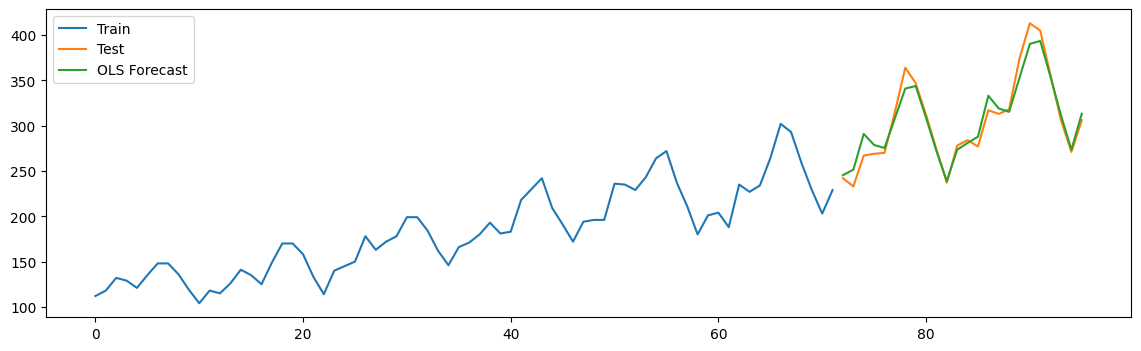

In [110]:
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(np.exp(pred_mult_add_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()

# **Compare the results**

In [111]:
data_c = {"Models":pd.Series(["RMSE_Linear","RMSE_Exp","RMSE_Quad","RMSE_Add_Sea","RMSE_Add_Sea_Quad","RMSE_Mult_Sea","RMSE_Mult_Add_Sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea,rmse_mult_add_sea])}
table_rmse=pd.DataFrame(data_c)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [113]:
e = pd.concat([table_rmse, table_evaluation], ignore_index=True)
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

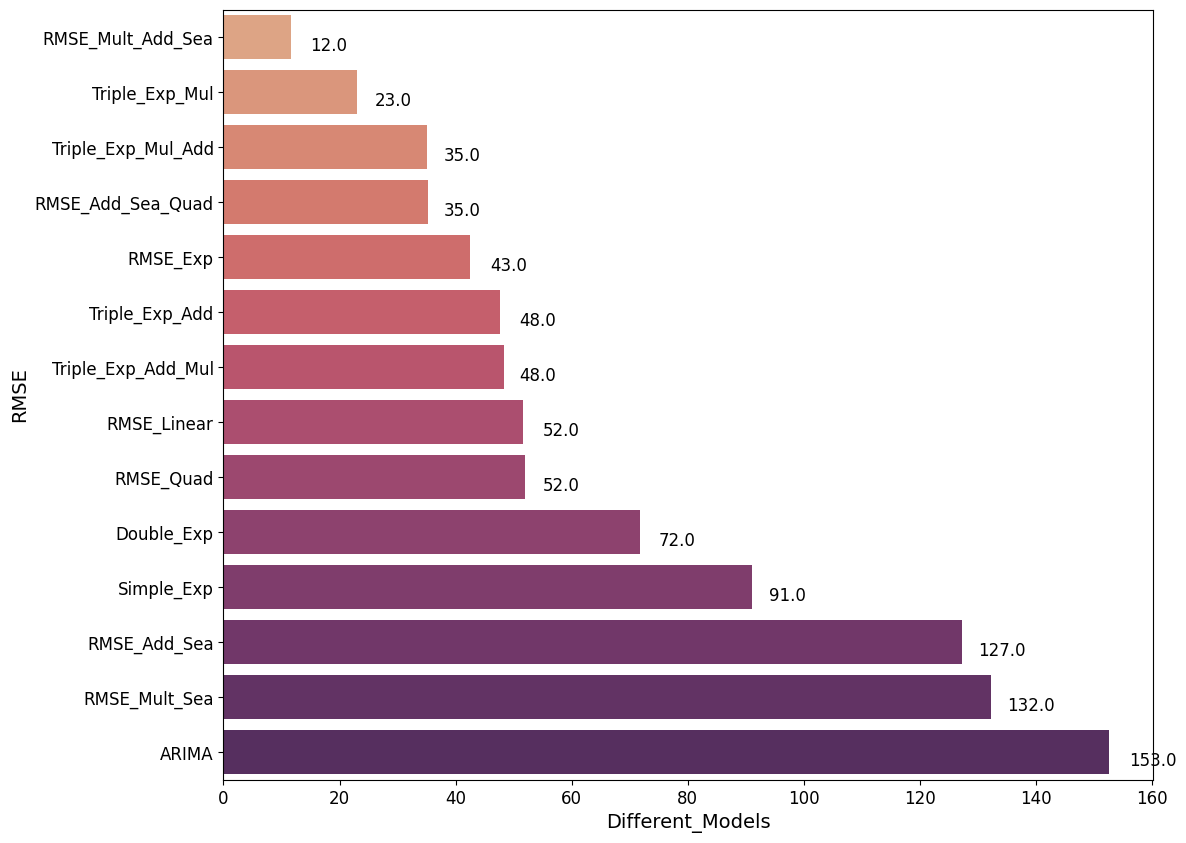

In [115]:
f, axe = plt.subplots(1,1, figsize=(12,10))
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe,palette='flare')
axe.set_xlabel('Different_Models', size=14)
axe.set_ylabel('RMSE', size=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize=12)

plt.show()

# **Conclusion:**
**Ordinary Least Sqaured with Multiplicative Additive Seasonality is the best model we have got so far with the lowest RMSE and lowest MAPE.**